In [195]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.stats import beta
from functools import partial

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

%matplotlib inline

Beta PDF is

$$
f(x,a,b) = \frac{x^{a - 1}(1 - x)^{b - 1}}{B(a,b)}
$$

where $B(a,b)$ is

$$
B(a,b) = \int_0^1 t^{a - 1}(1 - t)^{b - 1}\mathrm{d}t
$$

In [22]:
def B(a, b):
    def f(t):
        return t ** (a - 1) * (1 - t) ** (b - 1)

    return scipy.integrate.quad(f, 0, 1)[0]

In [20]:
beta(2, 2)

0.16666666666666669

In [199]:
def posterior_pdf(
    theta_1: float,
    theta_2: float,
    N_1: int,
    N_2: int,
    z_1: float,
    z_2: float,
) -> float:

    def out_of_bounds(v):
        return v > 1 or v < 0

    if out_of_bounds(theta_1) or out_of_bounds(theta_2):
        return 1e-12

    
    a = 2
    b = 2
    num = (
        theta_1 ** (z_1 + a - 1)
        * (1 - theta_1) ** (N_1 - z_1 + b - 1)
        * theta_2 ** (z_2 + a - 1)
        * (1 - theta_2) ** (N_2 - z_2 + b - 1)
    )

    den = (
        B(z_1 + a, N_1 - z_1 + b)
        * B(z_2 + a, N_2 - z_2 + b)
    )

    return num / den

In [150]:
def propose(current: np.array) -> np.array:
    mean = np.array([0, 0])
    covariance = np.diag([0.2, 0.2])
    proposed_delta = np.random.multivariate_normal(mean, covariance)
    return np.clip(current + proposed_delta, 0, 1)

In [198]:
def metropolis_sampling(
    pdf: callable,
    steps: int
) -> np.array:
    
    start = np.array([0.5, 0.5])
    samples = [start]

    for _ in range(steps):
        current = samples[-1]
        proposal = propose(current)
        args = proposal.tolist()
        prob_move = min(pdf(*proposal) / pdf(*current), 1)

        if np.random.rand() < prob_move:
            samples.append(proposal)
        else:
            samples.append(current)

    return np.array(samples)

In [205]:
def show(samples: np.array) -> None:
    plt.hist2d(samples[:, 0], samples[:, 1], bins=50)
    plt.title("Posterior Histogram")
    plt.xlabel("$\Theta_1$")
    plt.ylabel("$\Theta_2$")
    plt.show() 

In [152]:
N_1 = 8
N_2 = 7
z_1 = 6
z_2 = 2

In [196]:
posterior_pdf_ = partial(
    posterior_pdf,
    N_1=N_1,
    N_2=N_2,
    z_1=z_1,
    z_2=z_2,
)

samples = metropolis_sampling(posterior_pdf_, 100_000)

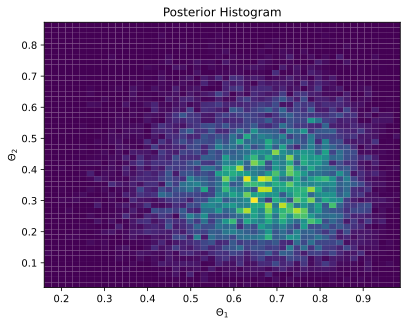

In [201]:
show(samples)

In [206]:
def bernoulli_sequence_likelihood(theta: float, z: float, N: int) -> float:
    return (theta ** z) * (1 - theta) ** (N - z)

prior = beta(2, 2).pdf

In [207]:
def likelihood_prior_pdf(
    theta_1: float,
    theta_2: float,
    N_1: int,
    N_2: int,
    z_1: float,
    z_2: float,
) -> float:

    # In the P(proposal) / P(current) fraction in the metropolis sampling,
    # we can get away with using the non-normalized PDF because the evidence
    # term p(D) is the same for both the P(proposal) and P(current) and cancels out.

    def out_of_bounds(v):
        return v > 1 or v < 0

    if out_of_bounds(theta_1) or out_of_bounds(theta_2):
        return 1e-12

    return (
        bernoulli_sequence_likelihood(theta_1, z_1, N_1)
        * bernoulli_sequence_likelihood(theta_2, z_2, N_2)
        * prior(theta_1)
        * prior(theta_2)
    )

In [208]:
likelihood_prior_pdf_ = partial(
    likelihood_prior_pdf,
    N_1=N_1,
    N_2=N_2,
    z_1=z_1,
    z_2=z_2,
)

samples = metropolis_sampling(likelihood_prior_pdf_, 100_000)

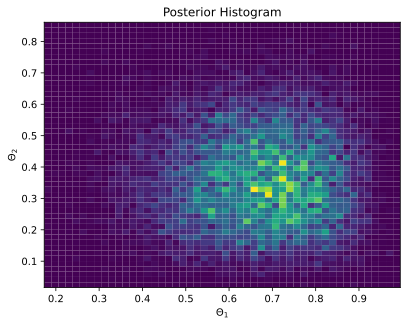

In [209]:
show(samples)